# groundup_004_meanshift

# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself.

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

## Imports

In [ ]:
import math, matplotlib.pyplot as plt, operator, torch
from fastdebug.utils import *

## torch.manual_seed(1)

In [ ]:
torch.manual_seed(1);

In [ ]:
check(torch.manual_seed)

signature: (seed) -> torch._C.Generator
__class__: <class 'function'>
__repr__: <function manual_seed>

__doc__:
Sets the seed for generating random numbers. Returns a
`torch.Generator` object.

Args:
    seed (int): The desired seed. Value must be within the inclusive range
        `[-0x8000_0000_0000_0000, 0xffff_ffff_ffff_ffff]`. Otherwise, a RuntimeError
        is raised. Negative inputs are remapped to positive values with the formula
        `0xffff_ffff_ffff_ffff + seed`.
__dict__: 
{}
metaclass: False
class: False
decorator: False
function: True
method: False


## centroids, torch.randint(low, high, size)

In [ ]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [ ]:
centroids = torch.randint(-35, 35, (n_clusters, 2)).float()

In [ ]:
centroids

tensor([[  0.,  24.],
        [-31.,   3.],
        [-32., -22.],
        [-14.,  26.],
        [ 14.,  17.],
        [-17.,  34.]])

In [ ]:
check(torch.randint, n=20)

signature: None
__class__: <class 'builtin_function_or_method'>
__repr__: <built-in method randint of type object>

__doc__:
randint(low=0, high, size, \*, generator=None, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor

Returns a tensor filled with random integers generated uniformly
between :attr:`low` (inclusive) and :attr:`high` (exclusive).

The shape of the tensor is defined by the variable argument :attr:`size`.

.. note::
    With the global dtype default (``torch.float32``), this function returns
    a tensor with dtype ``torch.int64``.

Args:
    low (int, optional): Lowest integer to be drawn from the distribution. Default: 0.
    high (int): One above the highest integer to be drawn from the distribution.
    size (tuple): a tuple defining the shape of the output tensor.

Keyword args:
    generator (:class:`torch.Generator`, optional): a pseudorandom number generator for sampling
    out (Tensor, optional): the output tensor.
    dty

## MultivariateNormal, torch.diag, mvn.sample
creating samples on centroids
docs on [MultivariateNormal](https://pytorch.org/docs/stable/distributions.html#multivariatenormal)

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [ ]:
torch.diag(tensor([5.,5.]))

tensor([[5., 0.],
        [0., 5.]])

In [ ]:
c1 = centroids[0]
c1

tensor([ 0., 24.])

In [ ]:
mvn = MultivariateNormal(c1, torch.diag(tensor([5.,5.])))
mvn

MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2]))

In [ ]:
check(mvn.sample)

signature: (sample_shape=torch.Size([]))
__class__: <class 'method'>
__repr__: <bound method Distribution.sample of MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2]))>

__doc__:
Generates a sample_shape shaped sample or sample_shape shaped batch of
samples if the distribution parameters are batched.
__dict__: 
{}
metaclass: False
class: False
decorator: False
function: False
method: True


In [ ]:
MultivariateNormal(c1, torch.diag(tensor([5.,5.]))).sample((100,)).shape

torch.Size([100, 2])

In [ ]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [ ]:
check(MultivariateNormal)

signature: (loc, covariance_matrix=None, precision_matrix=None, scale_tril=None, validate_args=None)
__class__: <class 'type'>
__repr__: <class 'torch.distributions.multivariate_normal.MultivariateNormal'>

__doc__:
Creates a multivariate normal (also called Gaussian) distribution
parameterized by a mean vector and a covariance matrix.

The multivariate normal distribution can be parameterized either
in terms of a positive definite covariance matrix :math:`\mathbf{\Sigma}`
or a positive definite precision matrix :math:`\mathbf{\Sigma}^{-1}`
or a lower-triangular matrix :math:`\mathbf{L}` with positive-valued
diagonal entries, such that
:math:`\mathbf{\Sigma} = \mathbf{L}\mathbf{L}^\top`. This triangular matrix
can be obtained via e.g. Cholesky decomposition of the covariance.

__dict__: 
mappingproxy({'__doc__': '\n'
                         '    Creates a multivariate normal (also called '
                         'Gaussian) distribution\n'
                         '    parameterized 

In [ ]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)

In [ ]:
data.shape

torch.Size([1500, 2])

## plot_centroids_sample, enumerate, plt.scatter, plt.plot
plotting centroids and sample

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [ ]:
centroids

tensor([[  0.,  24.],
        [-31.,   3.],
        [-32., -22.],
        [-14.,  26.],
        [ 14.,  17.],
        [-17.,  34.]])

In [ ]:
def plot_centroids_sample(centroids, data, n_samples):
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        plt.scatter(samples[:,0], samples[:,1], s=1)
        plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='k', mew=5)
        plt.plot(centroid[0], centroid[1], markersize=5, marker="x", color='m', mew=2)

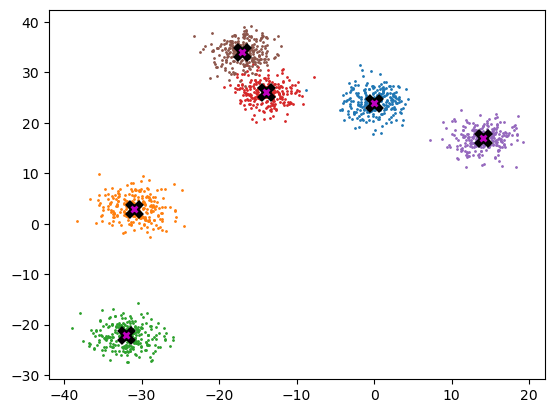

In [ ]:
plot_centroids_sample(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

## gaussian kernel

So here's the definition of the gaussian kernel, which you may remember from high school...

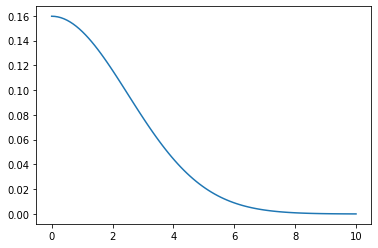

In [ ]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

x = torch.linspace(0,10,100)
plt.plot(x, gaussian(x,2.5));

 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [ ]:
X = data.clone()
x = data[0]
dist = torch.sqrt(((x-X)**2).sum(1))
dist[:8]

tensor([0.0000, 1.4130, 3.2164, 2.8909, 4.5990, 3.1394, 3.9166, 5.3368])

In [ ]:
weight = gaussian(dist, 2.5)
weight

tensor([1.5958e-01, 1.3602e-01, 6.9749e-02,  ..., 3.5634e-09, 1.7959e-10,
        2.7274e-16])

In [ ]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [ ]:
(weight[:,None]*X)

tensor([[-2.1094e-01,  3.9275e+00],
        [-2.9346e-01,  3.1928e+00],
        [-1.0870e-01,  1.4929e+00],
        ...,
        [-5.0652e-08,  1.1388e-07],
        [-2.6280e-09,  6.0300e-09],
        [-4.7550e-15,  1.0221e-14]])

## meanshift

In [ ]:
def meanshift(data):
    X = data.clone()
    for it in range(5):
        for i, x in enumerate(X):
            dist = torch.sqrt(((x-X)**2).sum(1))
            weight = gaussian(dist, 2.5)
            X[i] = (weight[:,None]*X).sum(0)/weight.sum()
    return X

In [ ]:
%time X=meanshift(data)

CPU times: user 1.22 s, sys: 1.5 ms, total: 1.22 s
Wall time: 1.22 s


We can see that mean shift clustering has almost reproduced our original clustering. The one exception are the very close clusters, but if we really wanted to differentiate them we could lower the bandwidth.

What is impressive is that this algorithm nearly reproduced the original clusters without telling it how many clusters there should be.

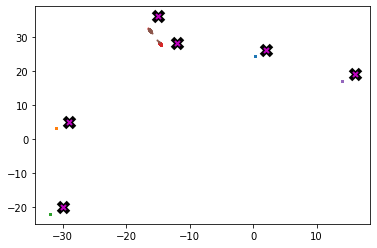

In [ ]:
plot_centroids_sample(centroids+2, X, n_samples)

All the computation is happening in the <tt>for</tt> loop, which isn't accelerated by pytorch. Each iteration launches a new cuda kernel, which takes time and slows the algorithm down as a whole. Furthermore, each iteration doesn't have enough processing to do to fill up all of the threads of the GPU. But at least the results are correct...

We should be able to accelerate this algorithm with a GPU.

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [ ]:
def dist_b(a,b): return torch.sqrt(((a[None]-b[:,None])**2).sum(2))

In [ ]:
X=torch.rand(8,2)
x=torch.rand(5,2)
dist_b(X, x)

tensor([[0.6867, 0.4772, 0.7416, 0.4211, 0.4418, 0.5633, 0.6071, 0.5677],
        [0.7734, 0.2386, 0.8327, 0.4916, 0.1589, 0.7302, 0.4068, 0.2873],
        [0.6580, 0.5093, 0.6850, 0.6278, 0.5885, 0.8003, 0.3447, 0.4739],
        [0.5121, 0.5730, 0.5588, 0.3179, 0.5735, 0.3513, 0.6487, 0.6734],
        [0.5185, 0.4800, 0.5446, 0.5135, 0.5654, 0.6665, 0.3131, 0.4730]])

In [ ]:
bs=5
X = data.clone()
x = X[:bs]
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[1.9947e-01, 1.5541e-01, 5.4735e-02,  ..., 2.2132e-13, 2.0775e-15,
         1.6831e-24],
        [1.5541e-01, 1.9947e-01, 1.1173e-01,  ..., 3.1427e-13, 2.0317e-15,
         9.7350e-25],
        [5.4735e-02, 1.1173e-01, 1.9947e-01,  ..., 3.5939e-16, 9.4595e-19,
         3.9723e-29],
        [7.0175e-02, 3.1377e-02, 1.8560e-02,  ..., 5.2249e-18, 3.3886e-20,
         3.0925e-30],
        [1.4180e-02, 3.1085e-03, 1.1476e-03,  ..., 8.5815e-20, 8.2003e-22,
         9.4978e-32]])

In [ ]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [ ]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [ ]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [ ]:
num/div

tensor([[-0.5274, 24.3688],
        [-1.0042, 23.6233],
        [-0.7959, 22.5723],
        [ 1.0092, 24.4519],
        [ 1.8587, 25.1916]])

In [ ]:
from fastcore.all import chunked

In [ ]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2)
            num = (weight[...,None]*X[None]).sum(1)
            div = weight.sum(1, keepdim=True)
            X[s] = num/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [ ]:
data = data.cuda()

In [ ]:
data

tensor([[ -1.3219,  24.6122],
        [ -2.1575,  23.4727],
        [ -1.5585,  21.4045],
        ...,
        [-14.2147,  31.9600],
        [-14.6337,  33.5766],
        [-17.4343,  37.4739]], device='cuda:0')

In [ ]:
meanshift(data)

tensor([[  0.2856,  24.2307],
        [  0.2856,  24.2307],
        [  0.2856,  24.2307],
        ...,
        [-17.1203,  34.0656],
        [-17.1203,  34.0656],
        [-17.1203,  34.0656]], device='cuda:0')

In [ ]:
X = meanshift(data).cpu()

In [ ]:
%timeit -n 1 X = meanshift(data).cpu()

4.5 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


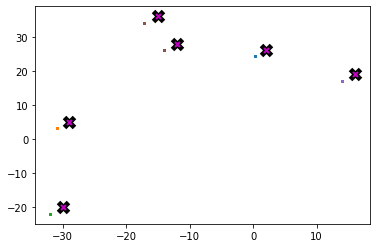

In [ ]:
plot_data(centroids+2, X, n_samples)